### 论文中的一些核心信息要点

In [60]:
#我们建立一个高斯混合模型，模型的分布组成数K固定，每个分布的均值和方差也固定，不固定的是这些分布的组合权重。
#星期有周期性，我们通过固定每一周同一地点的分布组合权重相同。
#上面这种周期性的刻画还可以有很多延伸，比如我们可以将节假日给排除出去（改变固定的权重），或者将午夜时间都通过这种方式进行“相似性”刻画。

#separate conditionally autoregressive (CAR) prior 被用来刻画每一个混合权重序列。而且该模型常用来刻画相似的时间序列
#（每一个位置都由一组高斯混合模型来刻画，而每一组高斯混合模型对应着一组改变的权重时间序列，因为只有组合权重是改变的）
#我们用CAR捕获自相关性和每日周期性。


#我们认为每一个时刻，充分依赖：上面一个时刻，下面一个时刻（代表了短期的序列依赖性）；昨天的此刻，和明天的此刻（代表了daily seasonality）


#用贝叶斯估计的方式给出超参数和先验分布

#原图中只显示了 0.25维度 0.7-0.8经度左右

## 数据读取和预处理

In [61]:
import numpy as np
import pandas as pd
pos_info = pd.read_excel('CanadianPostalCodes202204.xlsx')

In [62]:
data = pd.read_excel('Toronto.xlsx')

In [63]:
del pos_info['CITY']
del pos_info['PROVINCE_ABBR']
del pos_info['TIME_ZONE']

pos_info['POSTAL_CODE'] = pos_info['POSTAL_CODE'].apply(lambda x:x[:3])

### 根据位置code模拟经纬度

In [64]:
area_type = list(set(data['Forward_Sortation_Area']))
for area in area_type:
    all_index = list(data[data['Forward_Sortation_Area'] == area].index)
    temp = pos_info[pos_info['POSTAL_CODE'] == area]
    temp.reset_index(inplace = True)
    if len(temp) == 0:
        continue
    select_index = np.random.randint(low=0, high=len(temp), size=(len(all_index),))
    data.loc[all_index,'longitude'] = list(temp.loc[select_index,'LONGITUDE'])
    data.loc[all_index,'latitude'] = list(temp.loc[select_index,'LATITUDE'])

In [65]:
area_type = list(set(data['Forward_Sortation_Area']))

In [66]:
data.dropna(inplace = True)
data = data[(data['longitude'] > -79.65) & (data['longitude'] < -79.1)]
data = data[(data['latitude'] > 43.58) & (data['latitude'] < 43.84)]
data.reset_index(inplace = True)

In [67]:
data = data[['Dispatch_Time','longitude','latitude']]

#### 时间项预处理

In [68]:
import warnings
import datetime
warnings.filterwarnings("ignore")

#对时间数据进行处理，这里面格式都不一致。
def solve_time(x):
    if type(x) is datetime.datetime:
        return x
    else:
        year = 2000 + int(x.split('/')[-1].split(' ')[0])
        month = int(x.split('/')[0])
        day = int(x.split('/')[1])
        hour = int(x.split('/')[-1].split(' ')[1].split(':')[0])
        minute = int(x.split('/')[-1].split(' ')[1].split(':')[1])
        return datetime.datetime(year,month,day,hour,minute)

def get_hour(x):
    return datetime.datetime(x.year,x.month,x.day,x.hour)
    
data['Dispatch_Time'] = data['Dispatch_Time'].apply(solve_time)
data['hour_time'] = data['Dispatch_Time'].apply(get_hour)

### 经纬度转换为公里距离

In [69]:
#经度上横跨 40km 纬度上跨30km
def change_longtitude(x):
    return (x - (-79.375)) * (40 / 0.55)
def change_latitude(x):
    return (x - (43.71)) * (30 / 0.26)

data['longitude'] = data['longitude'].apply(change_longtitude)
data['latitude'] = data['latitude'].apply(change_latitude)

### 救护车案件分布视图

Text(0, 0.5, 'Kilometers northward from center of toronto')

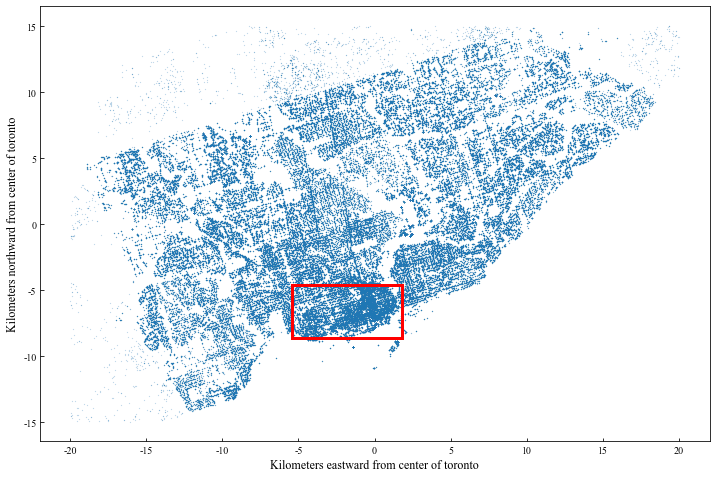

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.plot(data['longitude'],data['latitude'],'.',markersize = 0.2)
x_min = change_longtitude(-79.45)
y_min = change_latitude(43.635)
x_max = change_longtitude(-79.35)
y_max = change_latitude(43.67)
plt.plot([x_min,x_min],[y_min,y_max],'r-',linewidth = 3)
plt.plot([x_max,x_max],[y_min,y_max],'r-',linewidth = 3)
plt.plot([x_min,x_max],[y_min,y_min],'r-',linewidth = 3)
plt.plot([x_min,x_max],[y_max,y_max],'r-',linewidth = 3)
#plt.xlim(-79.65,-79.1)
#plt.ylim(43.58,43.84)
plt.xlabel('Kilometers eastward from center of toronto',fontsize = 12)
plt.ylabel('Kilometers northward from center of toronto',fontsize = 12)

### 特殊区域案件比例和自相关性分析

In [71]:

special_area = data[(data['longitude'] > x_min) & (data['longitude'] < x_max)]
special_area = special_area[(special_area['latitude'] > y_min) & (special_area['latitude'] < y_max)]
special_area.reset_index(inplace = True)

In [72]:
special_area = special_area[['hour_time','Dispatch_Time','longitude','latitude']]

In [73]:
#我们也聚焦到一个月内去对比分析，类比论文中图1b。
#由于21年没有完整的一个月的数据，比如二月份，只有从17号到28号的，所以我们把部分一月的和部分三月的数据放进来，凑够336个时间段（28*12）
temp1 = special_area[(special_area['Dispatch_Time'] > datetime.datetime(2021,1,1)) &(special_area['Dispatch_Time'] < datetime.datetime(2021,3,17))]
temp2 = data[(data['Dispatch_Time'] > datetime.datetime(2021,1,1)) &(data['Dispatch_Time'] < datetime.datetime(2021,3,17))]

count_list1 = np.array(temp1.groupby('hour_time')['Dispatch_Time'].count())
count_list2 = np.array(temp2.groupby('hour_time')['Dispatch_Time'].count())

In [74]:
from statsmodels.graphics.tsaplots import plot_acf

#2hour为一个单位
length = 336
count1 = count_list1[::2][:length] + count_list1[1::2][:length]
count2 = count_list2[::2][:length] + count_list2[1::2][:length]

month_2 = pd.DataFrame(columns = ['date','value'])
month_2['value'] = count1/count2
temp_list = [datetime.datetime(2021,2,1)]
for i in range(length - 1):
    temp_list.append(temp_list[-1] + datetime.timedelta(hours=2))
month_2['date'] = temp_list

# Select relevant data, index by Date
month_2 = month_2[['date', 'value']].set_index(['date'])

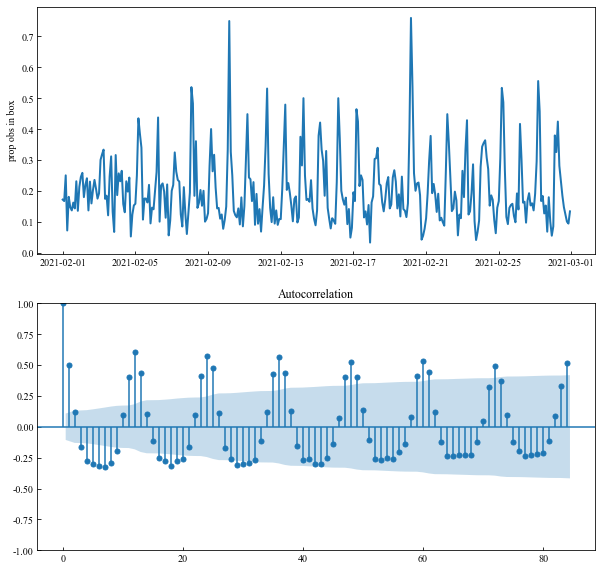

In [75]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)
plt.plot(month_2,linewidth = 2)
plt.ylabel('prop obs in box',fontsize = 10)

# Calculate the ACF (via statsmodel)
plot_acf(month_2, lags= 84, ax = fig.add_subplot(2,1,2))
# Show the data as a plot (via matplotlib)
plt.show()

## 高斯混合模型建模

In [76]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture
#color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

# Fit a Gaussian mixture with EM using five components
#gmm = mixture.GaussianMixture(n_components=15, covariance_type="full").fit(X)
#plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, "Gaussian Mixture")
#plot_only_ellipse(X, gmm.predict(X), gmm.means_, gmm.covariances_, gmm.weights_, 0, "Gaussian Mixture")

In [77]:
from sklearn import mixture

In [ ]:
X = np.array(data.loc[:,['longitude','latitude']])
# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=15, covariance_type="full").fit(X)
gmm = mixture.GaussianMixture(n_components=15, covariance_type="full").fit(X)

In [ ]:
def plot_only_ellipse(X, Y_, means, covariances,weights, index, title):
    splot = plt.subplot(1, 1, 1)
    for i, (mean, covar,weight) in enumerate(zip(means, covariances,weights)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0, color='black')
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color='black')
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.8 * (weight - min(weights)) / (max(weights) - min(weights)))
        splot.add_artist(ell)

    #plt.xticks(())
    #plt.yticks(())
    plt.title(title)


plt.figure(figsize = (12,8))
plot_only_ellipse(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_,dpgmm.weights_,0, "Bayesian Gaussian Mixture with a Dirichlet process prior",)
plt.show()

In [ ]:
plt.figure(figsize = (12,8))
plot_only_ellipse(X, gmm.predict(X), gmm.means_, gmm.covariances_,gmm.weights_,0, "Gaussian Mixture",)
plt.show()

---

### 等高线图

**论文中绘制等高线图，对比周三早上和晚上的救护车需求密度的不同。**

**同时对比以上两个不同时段上不同components模型的结果**

In [ ]:
#首先获取周三不同时刻的训练数据

data_wendsday_2_4 = data[(data['hour_time'].apply(lambda x: x.weekday()) == 2) & (data['hour_time'].apply(lambda x: x.hour).isin([2,3]))]
data_wendsday_14_16 = data[(data['hour_time'].apply(lambda x: x.weekday()) == 2) & (data['hour_time'].apply(lambda x: x.hour).isin([14,15]))]

In [ ]:
#训练四个模型
X_wendsday_2_4 = np.array(data_wendsday_2_4.loc[:,['longitude','latitude']])
dpgmm_1 = mixture.BayesianGaussianMixture(n_components=15, covariance_type="full").fit(X_wendsday_2_4)
dpgmm_3 = mixture.BayesianGaussianMixture(n_components=19, covariance_type="full").fit(X_wendsday_2_4)

X_wendsday_14_16 = np.array(data_wendsday_14_16.loc[:,['longitude','latitude']])
dpgmm_2 = mixture.BayesianGaussianMixture(n_components=15, covariance_type="full").fit(X_wendsday_14_16)
dpgmm_4 = mixture.BayesianGaussianMixture(n_components=19, covariance_type="full").fit(X_wendsday_14_16)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture
plt.figure(figsize = (15,10))
# display predicted scores by the model as a contour plot
x_point = np.linspace(-20.0, 20.0)
y_point = np.linspace(-15.0, 15.0)
X_point, Y_point = np.meshgrid(x_point, y_point)
XX = np.array([X_point.ravel(), Y_point.ravel()]).T
Z_point = -dpgmm_2.score_samples(XX)
Z_point = Z_point.reshape(X_point.shape)

levels = np.arange(np.min(Z_point), 9, 0.5)
color_list = []
for level in levels:
    #颜色有点淡，因为Z_point最小值是3-4左右。所以整体加深一点
    level = level - np.min(Z_point)
    color_list.append((level / 9,level / 9,level / 9))
CS = plt.contourf(X_point, Y_point, Z_point,levels=levels, colors = color_list)

CB = plt.colorbar(CS, shrink=0.8, extend="both")
#plt.scatter(X[:, 0], X[:, 1],0.001, color = 'g')

plt.title("posterior log spatial density using 15 components for Wednesday 2–4 p.m", fontsize = 18)
plt.axis("tight")
plt.xlabel('Kilometers eastward from center of toronto',fontsize = 12)
plt.ylabel('Kilometers northward from center of toronto',fontsize = 12)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture
plt.figure(figsize = (15,10))
# display predicted scores by the model as a contour plot
x_point = np.linspace(-20.0, 20.0)
y_point = np.linspace(-15.0, 15.0)
X_point, Y_point = np.meshgrid(x_point, y_point)
XX = np.array([X_point.ravel(), Y_point.ravel()]).T
Z_point = -dpgmm_1.score_samples(XX)
Z_point = Z_point.reshape(X_point.shape)

levels = np.arange(np.min(Z_point), 9, 0.5)
color_list = []
for level in levels:
    level = level - np.min(Z_point)
    color_list.append((level / 9,level / 9,level / 9))
CS = plt.contourf(X_point, Y_point, Z_point,levels=levels, colors = color_list)

CB = plt.colorbar(CS, shrink=0.8, extend="both")
#plt.scatter(X[:, 0], X[:, 1],0.001, color = 'g')

plt.title("posterior log spatial density using 15 components for Wednesday 2–4 a.m", fontsize = 18)
plt.axis("tight")
plt.xlabel('Kilometers eastward from center of toronto',fontsize = 12)
plt.ylabel('Kilometers northward from center of toronto',fontsize = 12)
plt.show()

In [ ]:
plt.figure(figsize = (15,10))
# display predicted scores by the model as a contour plot
x_point = np.linspace(-20.0, 20.0)
y_point = np.linspace(-15.0, 15.0)
X_point, Y_point = np.meshgrid(x_point, y_point)
XX = np.array([X_point.ravel(), Y_point.ravel()]).T
Z_point = -dpgmm_3.score_samples(XX)
Z_point = Z_point.reshape(X_point.shape)

levels = np.arange(np.min(Z_point), 9, 0.5)
color_list = []
for level in levels:
    #颜色有点淡，因为Z_point最小值是3-4左右。所以整体加深一点
    level = level - np.min(Z_point)
    color_list.append((level / 9,level / 9,level / 9))
CS = plt.contourf(X_point, Y_point, Z_point,levels=levels, colors = color_list)

CB = plt.colorbar(CS, shrink=0.8, extend="both")
#plt.scatter(X[:, 0], X[:, 1],0.001, color = 'g')

plt.title("posterior log spatial density using 19 components for Wednesday 2–4 p.m", fontsize = 18)
plt.axis("tight")
plt.xlabel('Kilometers eastward from center of toronto',fontsize = 12)
plt.ylabel('Kilometers northward from center of toronto',fontsize = 12)
plt.show()

In [ ]:
plt.figure(figsize = (15,10))
# display predicted scores by the model as a contour plot
x_point = np.linspace(-20.0, 20.0)
y_point = np.linspace(-15.0, 15.0)
X_point, Y_point = np.meshgrid(x_point, y_point)
XX = np.array([X_point.ravel(), Y_point.ravel()]).T
Z_point = -dpgmm_4.score_samples(XX)
Z_point = Z_point.reshape(X_point.shape)

levels = np.arange(np.min(Z_point), 9, 0.5)
color_list = []
for level in levels:
    level = level - np.min(Z_point)
    color_list.append((level / 9,level / 9,level / 9))
CS = plt.contourf(X_point, Y_point, Z_point,levels=levels, colors = color_list)

CB = plt.colorbar(CS, shrink=0.8, extend="both")
#plt.scatter(X[:, 0], X[:, 1],0.001, color = 'g')

plt.title("posterior log spatial density using 19 components for Wednesday 2–4 a.m", fontsize = 18)
plt.axis("tight")
plt.xlabel('Kilometers eastward from center of toronto',fontsize = 12)
plt.ylabel('Kilometers northward from center of toronto',fontsize = 12)
plt.show()

### PA值计算
**蒙特卡洛算法求解**

In [ ]:
#首先获取需要计算pa值的部分数据

data_pa = data[(data['Dispatch_Time'] > datetime.datetime(2020,1,1)) &(data['Dispatch_Time'] < datetime.datetime(2021,3,31))]
data_pa1 = data[(data['hour_time'].apply(lambda x: x.weekday()) == 2)]
data_pa2 = data[(data['hour_time'].apply(lambda x: x.weekday()) == 1)]

X_pa1 = np.array(data_pa1.loc[:,['longitude','latitude']])
dpgmm_pa1 = mixture.BayesianGaussianMixture(n_components=15, covariance_type="full").fit(X_pa1)
X_pa2 = np.array(data_pa2.loc[:,['longitude','latitude']])
dpgmm_pa2 = mixture.BayesianGaussianMixture(n_components=15, covariance_type="full").fit(X_pa2)


x_point = np.linspace(-20.0, 20.0)
y_point = np.linspace(-15.0, 15.0)
X_point, Y_point = np.meshgrid(x_point, y_point)
XX = np.array([X_point.ravel(), Y_point.ravel()]).T
Z_point1 = -dpgmm_pa1.score_samples(XX)
Z_point2 = -dpgmm_pa2.score_samples(XX)
Z_point1 = Z_point1.reshape(X_point.shape)
Z_point2 = Z_point2.reshape(X_point.shape)

In [ ]:
answer1 = []
for i in range(len(x_point) -1):
    for j in range(len(y_point) - 1):
        
        temp_ = data_pa1[(data_pa1['longitude'] < x_point[i+1]) & (data_pa1['longitude'] > x_point[i])]
        temp_ = temp_[(temp_['latitude'] < y_point[j+1]) & (temp_['latitude'] > y_point[j])]
        predict = len(temp_)
        true = -dpgmm_pa1.score_samples(np.array([[x_point[i],y_point[j]]]))[0]
        if true < np.min(Z_point):
            continue
        answer1.append([predict,true])

answer2 = []
for i in range(len(x_point) -1):
    for j in range(len(y_point) - 1):
        
        temp_ = data_pa2[(data_pa2['longitude'] < x_point[i+1]) & (data_pa2['longitude'] > x_point[i])]
        temp_ = temp_[(temp_['latitude'] < y_point[j+1]) & (temp_['latitude'] > y_point[j])]
        predict = len(temp_)
        true = -dpgmm_pa2.score_samples(np.array([[x_point[i],y_point[j]]]))[0]
        if true < np.min(Z_point):
            continue
        answer2.append([predict,true])

In [ ]:
answer1 = np.array(answer1)
all_num = np.sum(answer1[:,0])
all_num2 = np.sum(answer1[:,1])
predict_p = (answer1[:,1] / all_num2)
true_p = (answer1[:,0] / all_num)
print('March pa值：%.6f,(+- %.6f)'%(np.log(np.mean(abs(predict_p - true_p))),np.std(abs(predict_p - true_p))))

In [ ]:
answer2 = np.array(answer2)
all_num = np.sum(answer2[:,0])
all_num2 = np.sum(answer2[:,1])
predict_p = (answer2[:,1] / all_num2)
true_p = (answer2[:,0] / all_num)
print('February pa值：%.6f,(+- %.6f)'%(np.log(np.mean(abs(predict_p - true_p))),np.std(abs(predict_p - true_p))))

## 模型评估

**模拟40-50个救护车站点**

In [ ]:
from random import sample

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.plot(data['longitude'],data['latitude'],'.',markersize = 0.2,alpha = 0.3)
index_list = sample(list(np.arange(len(data))),44)
plt.plot(data.loc[index_list,'longitude'],data.loc[index_list,'latitude'],'k.',markersize = 20)
#plt.xlim(-79.65,-79.1)
#plt.ylim(43.58,43.84)
plt.xlabel('Kilometers eastward from center of toronto',fontsize = 12)
plt.ylabel('Kilometers northward from center of toronto',fontsize = 12)

**对一周内每两个小时，建立不同权重参数的高斯混合模型**

**方便起见，我们在一月上训练在二月上做测试**

In [ ]:
train_data = data[(data['Dispatch_Time'] > datetime.datetime(2021,1,1)) &(data['Dispatch_Time'] < datetime.datetime(2021,1,31))]
test_data = data[(data['Dispatch_Time'] > datetime.datetime(2021,2,1)) &(data['Dispatch_Time'] < datetime.datetime(2021,2,28))]

weekday_list = [0,1,2,3,4,5,6]

hour_list = [[0,1],[2,3],[4,5],[6,7],[8,9],[10,11],
                [12,13],[14,15],[16,17],[18,19],[20,21],[22,23]]

#假设有200辆救护车
ambu_total_num = 100

#weekday_list = [0]
#hour_list = [[0,1]]
answer1 = []
answer2 = []
answer3 = []
prop = []
for weekday in weekday_list:
    for hour in hour_list:
        data_week_2hour = train_data[(train_data['hour_time'].apply(lambda x: x.weekday()) == weekday) & (train_data['hour_time'].apply(lambda x: x.hour).isin(hour))]
        X_weekday_2hour = np.array(data_week_2hour.loc[:,['longitude','latitude']])
        dpgmm_temp = mixture.BayesianGaussianMixture(n_components=15, covariance_type="full").fit(X_weekday_2hour)
        
        #计算模拟的救护车站点的实时救护车数量
        ambu_number_ = -dpgmm_temp.score_samples(np.array(data.loc[index_list,['longitude','latitude']]))
        ambu_number = np.round(100 * ambu_number_/sum(ambu_number_))
        
        #在测试集测试我们模拟的救护车分布状况下，前往救援需要等待的时间。
        test_week_2hour = test_data[(test_data['hour_time'].apply(lambda x: x.weekday()) == weekday) & (test_data['hour_time'].apply(lambda x: x.hour).isin(hour))]
        
        temp1 = np.array(data.loc[index_list,['longitude','latitude']])
        temp2 = np.array(test_week_2hour.loc[:,['longitude','latitude']])
        total_events = []
        
        #突发事件归最近的救护车站点管理
        for i in range(len(temp2)):
            total_events.append(np.argmin(np.linalg.norm(temp1 - temp2[i],axis = 1)))
            answer3.append(np.min(np.linalg.norm(temp1 - temp2[i],axis = 1)))
        total_events = np.array(total_events)
        #统计出每个站点每两个小时需要接应的突发事件，计算出需要等待的响应时间,假设任一事件处理时长为30min。
        temp3 = pd.value_counts(total_events).sort_index()
        keys_list = temp3.keys()
        waste_time1 = 0
        waste_time2 = 0
        for key in keys_list:
            if temp3[key] - ambu_number[key] * 4 > 0:
                waste_time1 += (temp3[key] - ambu_number[key] * 4)
            else:
                waste_time2 += (temp3[key]//ambu_number[key])
        answer1.append(waste_time1)
        answer2.append(waste_time2)
        #prop.append(waste_time/sum(total_events))
        

In [ ]:
##默认车速是论文中的46.44km/hr
answer3 = np.array(answer3)
need_time = (answer3 / 46.44) * 3600

##按照论文中每10s一档。
total_num = len(need_time)
new_plot_d = []
std = []
for i in range(0,31):
    num = len(np.where((need_time > i*10) &(need_time < (i+1)*10))[0])
    std.append(np.var(need_time[np.where((need_time > i*10) &(need_time < (i+1)*10))[0]]))
    new_plot_d.append(num)
new_plot_d = np.array(new_plot_d)
std = np.array(std)

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(np.arange(0,310,10),new_plot_d/total_num)
plt.fill_between(np.arange(0,310,10),new_plot_d/total_num, y2=new_plot_d/total_num + (std / total_num),alpha = 0.1,color = 'b')
plt.fill_between(np.arange(0,310,10),new_plot_d/total_num, y2=new_plot_d/total_num - (std / total_num),alpha = 0.1,color = 'b')

---
## 柏松混合分布

In [ ]:
import pymc3 as pm
import numpy as np
import random

### 先做一些可视化

In [ ]:
plot_list = []
for i in range(7):
    temp_list = []
    for j in range(12):
        temp_ = data[(data['hour_time'].apply(lambda x: x.hour).isin([2*j,2*j + 1])) & (data['hour_time'].apply(lambda x: x.weekday() == i))]
        temp_list.append(len(temp_))
    plot_list.append(temp_list)

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman')
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
plt.rcParams['xtick.direction'] = 'in'#将y轴的刻度方向设置向内
import numpy as np
# pre-datas
plt.figure(figsize = (22,8))
x = ['00h-02h','02h-04h','04h-06h','06h-08h','08h-10h','10h-12h','12h-14h','14h-16h','16h-18h','18h-20h','20h-22h','22h-24h']
plt.plot(x, np.array(plot_list[0])/sum(plot_list[0]), lw=1, c='red', marker='s', ms=8, label='Monday')
plt.plot(x, np.array(plot_list[1])/sum(plot_list[1]), lw=1, c='g', marker='o', ms=8, label='Tuesday')
plt.plot(x, np.array(plot_list[2])/sum(plot_list[2]), lw=1, c='k', marker='^', ms=8, label='Wednesday')
plt.plot(x, np.array(plot_list[3])/sum(plot_list[3]), lw=1,  marker='s', ms=8, label='Thirsday')
plt.plot(x, np.array(plot_list[4])/sum(plot_list[4]), lw=1, marker='p', ms=8, label='Friday')
plt.plot(x, np.array(plot_list[5])/sum(plot_list[5]), lw=1,linestyle ='--', marker='h', ms=8, label='Saturday')
plt.plot(x, np.array(plot_list[6])/sum(plot_list[6]), lw=1,linestyle ='--', marker='+', ms=8, label='Sunday')
# plt-style 
#plt.xticks()  # x轴的刻度
#plt.xlim(0.5, 4.5)  # x轴坐标范围
#plt.ylim(20, 80)  # y轴坐标范围
plt.legend(prop={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
bwith = 1 #边框宽度设置为2
ax = plt.gca()#获取边框
legend=ax.legend(fontsize=24,loc='best')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(2)

ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
plt.tick_params(width=2,length = 8)
plt.xlabel('Timeslot',fontsize = 24)  # x轴标注
plt.ylabel('Mean number of calls',fontsize = 24)  # y轴标注
plt.legend()  # 图例
plt.savefig('ablation1.svg',dpi = 300)  # 保存图片
plt.show()

In [ ]:
temp_data_ = data[data['hour_time'].apply(lambda x: x.year) == 2017]
day_count = temp_data_.groupby(temp_data_['hour_time'].apply(lambda x: x.date())).count().sort_index()

x_value = day_count.index[:-1]
y_value1 = day_count.values[:,0][1:]
y_value2 = day_count.values[:,0][1:] - day_count.values[:,0][:-1]
x_v2 = []
y_v2 = []
y_v2_ = []
for i in range(len(x_value)):
    if x_value[i].weekday() in [5,6]:
        x_v2.append(x_value[i])
        y_v2.append(y_value1[i])
        y_v2_.append(y_value2[i])
        
plt.figure(figsize = (8,8))
plt.subplot(211)
plt.plot(x_value, y_value1, lw=1, c='red')
plt.plot(x_v2, y_v2,'*', c='red')
plt.ylabel('Number of calls')
plt.subplot(212)
plt.plot(x_value, y_value2, lw=1, c='red')
plt.plot(x_v2, y_v2_, '*', c='red')
plt.ylabel('N_day - N_day-1')

In [ ]:
import copy
#def prior_inputdata_get1(prior_type,prior_content,raw_data):
def prior_inputdata_get1(prior_type_list,prior_content_list,raw_data):
    #该函数的目的主要在于根据指定的prior_type类型去生成对应的输入数据。
    #目前我们默认的prior_type包括：
    #1.时间：一天以两小时为单位，即一天共分为12个time zone。
    #2.季节：包括春夏秋冬四个季度。
    #3.星期，包括周一到周日七个选择。
    #4.节假日，即该预测时刻是否是节假日。
    #5.downtown，即该预测区域是否是中心城区。
    
    temp_data = copy.deepcopy(raw_data)
    for prior_type,prior_content in zip(prior_type_list,prior_content_list):
        if prior_type == 'time':
            #默认关于时间的prior_content属于[0,12),指代不同的time zone。0指代0点和1点，1指代2点和3点，2指代3点和4点，以此类推...
            temp_data = temp_data[temp_data['hour_time'].apply(lambda x: x.hour).isin([prior_content*2,prior_content*2 + 1])]
            temp_data.reset_index(inplace = True,drop = True)

        if prior_type == 'season':
            #默认关于四季的prior_content属于[0,4),指代不同的季节。0指代春，1指代夏，2指代秋，3指代冬。
            temp_data = temp_data[temp_data['hour_time'].apply(lambda x: x.month).isin([prior_content*3+1,prior_content*3+2,prior_content*3+3])]
            temp_data.reset_index(inplace = True,drop = True)            

        if prior_type == 'week':
            #默认关于星期的prior_content属于[0,7),指代是否是周末。0表示周一，1表示周二，以此类推。
            temp_data = temp_data[temp_data['hour_time'].apply(lambda x: x.weekday()) == prior_content]
            temp_data.reset_index(inplace = True,drop = True)    

        if prior_type == 'festival':
            #默认关于节假日的prior_content为[0,1],0表示不是节假日，1表示是节假日
            if prior_content == 1:
                temp_data1 = temp_data[(temp_data['hour_time'].apply(lambda x: x.day).isin([19])) & (temp_data['hour_time'].apply(lambda x: x.month) == 6)]
                temp_data2 = temp_data[(temp_data['hour_time'].apply(lambda x: x.day).isin([24,25,26,31])) & (temp_data['hour_time'].apply(lambda x: x.month) == 12)]
                temp_data3 = temp_data[(temp_data['hour_time'].apply(lambda x: x.day).isin([24])) & (temp_data['hour_time'].apply(lambda x: x.month) == 11)]
                temp_data = pd.concat((temp_data1,temp_data2,temp_data3))
                temp_data.reset_index(inplace = True,drop = True)
            else:
                temp_data1 = temp_data[(temp_data['hour_time'].apply(lambda x: x.day).isin([19])) & (temp_data['hour_time'].apply(lambda x: x.month) == 6)]
                temp_data2 = temp_data[(temp_data['hour_time'].apply(lambda x: x.day).isin([24,25,26,31])) & (temp_data['hour_time'].apply(lambda x: x.month) == 12)]
                temp_data3 = temp_data[(temp_data['hour_time'].apply(lambda x: x.day).isin([24])) & (temp_data['hour_time'].apply(lambda x: x.month) == 11)]
                temp_data_ = pd.concat((temp_data1,temp_data2,temp_data3))

                temp_data = temp_data.drop(temp_data_.index, axis=0)
                temp_data.reset_index(inplace = True,drop = True)

        if prior_type == 'downtown':
            #默认关于中心区域的prior_content为[0,1],0表示不是中心区域，1表示是中心区域
            if prior_content == 1:
                x_min = change_longtitude(-79.45)
                y_min = change_latitude(43.635)
                x_max = change_longtitude(-79.35)
                y_max = change_latitude(43.67)
                temp_data = temp_data[(temp_data['longitude'] > x_min) & (temp_data['longitude'] < x_max)]
                temp_data = temp_data[(temp_data['latitude'] > y_min) & (temp_data['latitude'] < y_max)]
                temp_data.reset_index(inplace = True,drop = True)
            else:
                x_min = change_longtitude(-79.45)
                y_min = change_latitude(43.635)
                x_max = change_longtitude(-79.35)
                y_max = change_latitude(43.67)
                temp_data_ = temp_data[(temp_data['longitude'] > x_min) & (temp_data['longitude'] < x_max)]
                temp_data_ = temp_data_[(temp_data_['latitude'] > y_min) & (temp_data_['latitude'] < y_max)]
                temp_data = temp_data.drop(temp_data_.index, axis=0)
                temp_data.reset_index(inplace = True,drop = True)
        
        if 100 < len(temp_data) < 1000:
            print("warning: 在该prior条件下，可供训练的数据量过少，可能导致模型表现较差。")
        if len(temp_data) < 100:
            print("error: 在该prior条件下，可供训练的数据量几乎为0，模型训练表现没有可信度。")
    return temp_data

## 处理一下人口和薪资数据

**首先找到对应区域code的经纬度信息**

**其次将研究区域聚焦到我们关心的市**

In [ ]:
import pandas as pd
salary_data = pd.read_csv('data/salary.csv')[['FSA','Total']].dropna()
population_data = pd.read_csv('data/population.csv')[['Geographic code','Population, 2016']].dropna()

In [ ]:
area_type = list(set(salary_data['FSA']))
for area in area_type:
    all_index = list(salary_data[salary_data['FSA'] == area].index)
    temp = pos_info[pos_info['POSTAL_CODE'] == area]
    temp.reset_index(inplace = True)
    if len(temp) == 0:
        continue
    salary_data.loc[all_index,'min_longitude'] = min(temp['LONGITUDE'])
    salary_data.loc[all_index,'max_longitude'] = max(temp['LONGITUDE'])
    salary_data.loc[all_index,'min_latitude'] = min(temp['LATITUDE'])
    salary_data.loc[all_index,'max_latitude'] = max(temp['LATITUDE'])

In [ ]:
area_type = list(set(population_data['Geographic code']))
for area in area_type:
    all_index = list(population_data[population_data['Geographic code'] == area].index)
    temp = pos_info[pos_info['POSTAL_CODE'] == area]
    temp.reset_index(inplace = True)
    if len(temp) == 0:
        continue
    population_data.loc[all_index,'min_longitude'] = min(temp['LONGITUDE'])
    population_data.loc[all_index,'max_longitude'] = max(temp['LONGITUDE'])
    population_data.loc[all_index,'min_latitude'] = min(temp['LATITUDE'])
    population_data.loc[all_index,'max_latitude'] = max(temp['LATITUDE'])

In [ ]:
salary_data = salary_data[(salary_data['min_longitude'] > -79.65) & (salary_data['max_longitude'] < -79.1) & (salary_data['min_latitude'] > 43.58) & (salary_data['max_latitude'] > 43.84)]
population_data = population_data[(population_data['min_longitude'] > -79.65) & (population_data['max_longitude'] < -79.1) & (population_data['min_latitude'] > 43.58) & (population_data['max_latitude'] > 43.84)]

salary_data.columns = ['FSA','Salary','min_longitude','max_longitude','min_latitude','max_latitude']
population_data.columns = ['FSA','Population','min_longitude','max_longitude','min_latitude','max_latitude']
pop_salary_data = pd.merge(population_data,salary_data,on = 'FSA')[['FSA','Population','Salary','min_longitude_x','max_longitude_x','min_latitude_x','max_latitude_x']]
pop_salary_data.columns = ['FSA','Population','Salary','min_longitude','max_longitude','min_latitude','max_latitude']

In [ ]:
pop_salary_data['min_longitude'] = pop_salary_data['min_longitude'].apply(change_longtitude)
pop_salary_data['max_longitude'] = pop_salary_data['max_longitude'].apply(change_longtitude)

pop_salary_data['min_latitude'] = pop_salary_data['min_latitude'].apply(change_latitude)
pop_salary_data['max_latitude'] = pop_salary_data['max_latitude'].apply(change_latitude)

In [ ]:
pop_salary_data['total_event'] = 0
for i in range(len(pop_salary_data)):
    length = len(data[(data['longitude'] > pop_salary_data.loc[i,'min_longitude']) & (data['longitude'] < pop_salary_data.loc[i,'max_longitude']) & (data['latitude'] > pop_salary_data.loc[i,'min_latitude'])& (data['latitude'] < pop_salary_data.loc[i,'max_latitude'])])
    pop_salary_data.loc[i,'total_event'] = length

In [ ]:
pop_salary_data['mean_salary'] = (pop_salary_data['Salary'] / pop_salary_data['Population']) * 10000

In [ ]:
import seaborn as sns
plt.figure(figsize = (20,8))
plt.subplot(231)
sns.regplot(x = 'Population',y = 'min_longitude',data = pop_salary_data)
plt.subplot(232)
sns.regplot(x = 'Population',y = 'min_latitude',data = pop_salary_data)
plt.subplot(233)
sns.regplot(x = 'Population',y = 'total_event',data = pop_salary_data)

plt.subplot(234)
sns.regplot(x = 'mean_salary',y = 'min_longitude',data = pop_salary_data)
plt.subplot(235)
sns.regplot(x = 'mean_salary',y = 'min_latitude',data = pop_salary_data)
plt.subplot(236)
sns.regplot(x = 'mean_salary',y = 'total_event',data = pop_salary_data)

## 对人口和薪资数据的说明
**其实从右上角那个图可以看出，人口和总收入是绝对正比的，换句话说薪资水平没有太大差异。**

**人口数越多，总事件数越多。这个点是我们真正需要得到的结论，也是后续建模需要的依据**

**所以我们更应该关注平均工资，从第二排中间这张图能看出，薪资和总事件数是略成反比的关系**

**当然人口数和薪资水平也是略成反比的关系，从右下图可以看出。**

**所以这些数据给我们的启示应当以区域来关注，它们是更广义上的downtown属性。即downtown是一个二值变量，即是或不是。而这里我们需要关注到每一个行政区域，然后根据其区域特性（如人口等）去给我们的混合分布模型的初始状态一个启发式的学习。**

---

In [ ]:
from sklearn.linear_model import LinearRegression
def prior_dist_get2(prior_type,pop_salary_data):
    #该函数的目的主要在于根据指定的prior_type类型去生成对应的概率分布微调比例。
    #目前我们默认的prior_type包括：
    #1.人口数据，各个区域的人口分布。
    #2.薪水数据，各个区域的薪资水平分布。
    if prior_type == 'Population':
        #默认关于人口的prior_content就是区域人口数据。
        modelRegL1 = LinearRegression()
        modelRegL1.fit(np.array(pop_salary_data['Population']).reshape(-1,1), np.array(((pop_salary_data['min_longitude'] + pop_salary_data['max_longitude'])/2)).reshape(-1,1))  # 模型训练：数据拟合
        modelRegL2 = LinearRegression()
        modelRegL2.fit(np.array(pop_salary_data['Population']).reshape(-1,1), np.array(((pop_salary_data['min_latitude'] + pop_salary_data['max_latitude'])/2)).reshape(-1,1))  # 模型训练：数据拟合

    if prior_type == 'salary':
        #默认关于薪水的prior_content就是区域薪资水平数据。
        modelRegL1 = LinearRegression()
        modelRegL1.fit((np.array(pop_salary_data['mean_salary'])).reshape(-1,1), np.array(((pop_salary_data['min_longitude'] + pop_salary_data['max_longitude'])/2)).reshape(-1,1))  # 模型训练：数据拟合
        modelRegL2 = LinearRegression()
        modelRegL2.fit((np.array(pop_salary_data['mean_salary'])).reshape(-1,1), np.array(((pop_salary_data['min_latitude'] + pop_salary_data['max_latitude'])/2)).reshape(-1,1))  # 模型训练：数据拟合
        
    if prior_type == 'both':
        #就是两个都考虑
        modelRegL1 = LinearRegression()
        modelRegL1.fit((np.array(pop_salary_data[['mean_salary','Population']])), np.array(((pop_salary_data['min_longitude'] + pop_salary_data['max_longitude'])/2)).reshape(-1,1))  # 模型训练：数据拟合
        modelRegL2 = LinearRegression()
        modelRegL2.fit((np.array(pop_salary_data[['mean_salary','Population']])), np.array(((pop_salary_data['min_latitude'] + pop_salary_data['max_latitude'])/2)).reshape(-1,1))  # 模型训练：数据拟合
    
    #后续可以添加设计其他的这种区域性的prior。
    return prior_type,modelRegL1.coef_[0],modelRegL2.coef_[0]

## 整体模型搭建

In [ ]:
def get_xy_distribution(distribution_x,distribution_y,prior1):
    len_x = len(distribution_x)
    len_y = len(distribution_y)
    x_point = np.linspace(min(prior1['longitude']),max(prior1['longitude']),len_x)
    y_point = np.linspace(min(prior1['latitude']),max(prior1['latitude']),len_y)
    X_point, Y_point = np.meshgrid(x_point, y_point)
    XX = np.array([X_point.ravel(), Y_point.ravel()]).T
    Z_point = []
    for i in range(len_y):
        for j in range(len_x):
            Z_point.append(distribution_x[j] * distribution_y[i])
    Z_point = np.array(Z_point) / sum(Z_point)
    Z_point = Z_point.reshape(X_point.shape)
    return Z_point

def mcmc_poisson_dist_fit(dis_num,obs_data):
    # n-Mixture Poisson using iterable of distributions.
    mix_num = dis_num
    with pm.Model() as model:
        lam_list = []
        for i in range(mix_num):
            lam_list.append(pm.Exponential('lam' + str(i+1), lam=1))

        pois_list = []
        for i in range(mix_num):
            pois_list.append(pm.Poisson.dist(mu=lam_list[i]))

        w = pm.Dirichlet('w', a=np.array([1] * mix_num))

        like = pm.Mixture('like', w=w, comp_dists = pois_list, observed=obs_data)
        trace = pm.sample(1000, n_init=10000,cores=1, random_seed=11)
    
    weight_ = trace.get_values('w')
    final_weight = np.mean(weight_[int(len(weight_) * 0.9):],axis = 0)

    final_freq = 0
    for i in range(mix_num):
        lam_ = trace.get_values('lam' + str(i+1))
        final_lam = np.mean(lam_[int(len(lam_) * 0.9):])
        x_ = np.random.poisson(lam=final_lam, size=10000)
        final_freq += final_weight[i] * (pd.Series(x_).value_counts(bins = range(0,int(np.ceil(max(obs_data)))),normalize = True).sort_index(ascending=True)).values
    #final_freq /= mix_num
    return final_freq


def poisson_mix(input_data,area_params = None,dis_num = 5,is_sample = True, plot_show = True):

    if is_sample == True:
        #对输入数据进行采样，因为有时候大几十万条训练时间太久了。
        if len(input_data) > 10000:
            input_data = input_data.loc[random.sample(range(len(input_data)),10000),:]
            input_data.reset_index(inplace = True,drop = True)
            
    input_data_x = np.array(input_data['longitude'])
    input_data_y = np.array(input_data['latitude'])

    #柏松分布不能有负数，我们整体平移数据即可
    obs_data_x = input_data_x - np.min(input_data_x)
    obs_data_y = input_data_y - np.min(input_data_y)

    if area_params != None:
        if area_params[0] == 'both':
            longtitude_change_params1 = area_params[1][0]
            latitude_change_params1 = area_params[2][0]
            longtitude_change_params2 = area_params[1][1]
            latitude_change_params2 = area_params[2][1]            
        else:
            longtitude_change_params = area_params[1][0]
            latitude_change_params = area_params[2][0]
            
            
    final_freq = mcmc_poisson_dist_fit(dis_num,obs_data_x)        
    if area_params != None:
        if area_params[0] == 'both':    
            final_freq = final_freq * (1 + np.linspace(-longtitude_change_params1,longtitude_change_params1,len(final_freq))) / sum(final_freq)
            final_freq = final_freq * (1 + np.linspace(-longtitude_change_params2,longtitude_change_params2,len(final_freq))) / sum(final_freq)
        else:
            final_freq = final_freq * (1 + np.linspace(-longtitude_change_params,longtitude_change_params,len(final_freq))) / sum(final_freq)
    
    #我们根据新的概率密度函数采个样。
    sample_num = len(input_data)
    cumsum_v = final_freq.cumsum()
    final_sample = []
    for _ in range(sample_num):
        temp_ = np.random.uniform()
        i = 0
        while i < len(cumsum_v):
            if temp_ < cumsum_v[i]:
                break
            i += 1
        final_sample.append(temp_ + i)
        
    final_freq2 = mcmc_poisson_dist_fit(dis_num,obs_data_y)
    if area_params != None:
        if area_params[0] == 'both':    
            final_freq2 = final_freq2 * (1 + np.linspace(-longtitude_change_params1,longtitude_change_params1,len(final_freq2))) / sum(final_freq2)
            final_freq2 = final_freq2 * (1 + np.linspace(-longtitude_change_params2,longtitude_change_params2,len(final_freq2))) / sum(final_freq2)
        else:
            final_freq2 = final_freq2 * (1 + np.linspace(-longtitude_change_params,longtitude_change_params,len(final_freq2))) / sum(final_freq2)
    
    cumsum_v2 = final_freq2.cumsum()
    final_sample2 = []
    for _ in range(sample_num):
        temp_ = np.random.uniform()
        i = 0
        while i < len(cumsum_v2):
            if temp_ < cumsum_v2[i]:
                break
            i += 1
        final_sample2.append(temp_ + i)
    
    
    if plot_show == True:    
        fig, ax = plt.subplots(figsize = (8,6))
        ax.hist(obs_data_x - np.min(obs_data_x), bins=30,stacked=True,
                histtype='step', lw=2,
                label='Observed data')
        ax.hist(np.array(final_sample) + 1, bins=30,stacked=True,
                histtype='step', lw=2,
                label='Mixture poisson predictive distribution')
        ax.legend(loc=1)
        plt.show()
        
        fig, ax = plt.subplots(figsize = (8,6))
        ax.hist(obs_data_y - np.min(obs_data_y), bins=30,stacked=True,
                histtype='step', lw=2,
                label='Observed data')
        ax.hist(np.array(final_sample2) + 1, bins=30,stacked=True,
                histtype='step', lw=2,
                label='Mixture poisson predictive distribution')
        ax.legend(loc=1)
        plt.show()
    
    #输出的时候，记得把预测值再整体平移回去
    return final_freq, final_freq2, np.array(final_sample) + np.min(input_data_x),np.array(final_sample2) + np.min(input_data_y)

### prior使用说明
**prior_inputdata_get1函数负责时间、季节、星期、节假日、downtown这些prior的输入。可以任意组合。如：**

- prior_inputdata_get1(['time'],[0],data)：表示时间在0-1点。
- prior_inputdata_get1(['season','time'],[2,1],data)：表示season在秋季，时间在2-4点。
- prior_inputdata_get1(['season','time'，'downtown'],[0,5,1],data)：表示season在春季，时间在10-12点，且是中心城区。
- prior_inputdata_get1(['holiday','week'],[1,3],data)：表示在节假日，在周四。

**prior_inputdata_get2函数负责人口、薪资这些prior的输入。可以任意组合。如：**
- prior_dist_get2('Population',pop_salary_data):考虑人口prior输入
- prior_dist_get2('salary',pop_salary_data):考虑薪资prior输入
- prior_dist_get2('both',pop_salary_data):考虑人口和薪资prior输入

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w, lam5, lam4, lam3, lam2, lam1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 124 seconds.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6009392264924195, but should be close to 0.8. Try to increase the number of tuning steps.
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w, lam5, lam4, lam3, lam2, lam1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 128 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


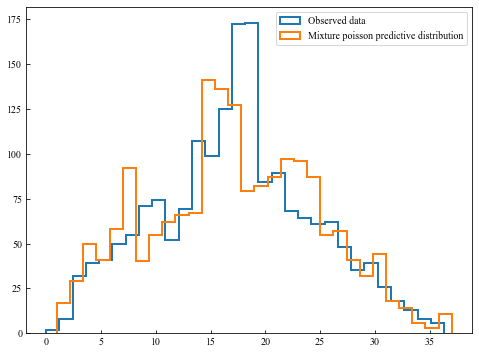

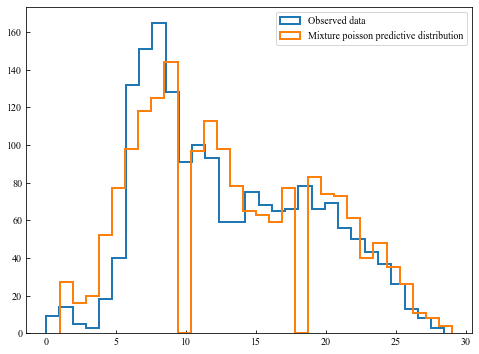

In [52]:
prior1 = prior_inputdata_get1(['season','time'],[2,1],data)
prior2 = prior_dist_get2('Population',pop_salary_data)

distribution_number = 5
distribution_x, distribution_y, sample_x, sample_y = poisson_mix(prior1,prior2,distribution_number)
Z_point = get_xy_distribution(distribution_x,distribution_y,prior1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w, lam5, lam4, lam3, lam2, lam1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 140 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w, lam5, lam4, lam3, lam2, lam1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 104 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


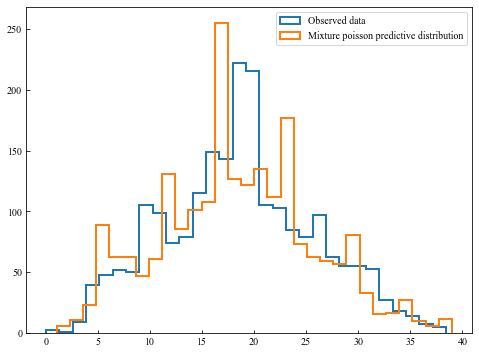

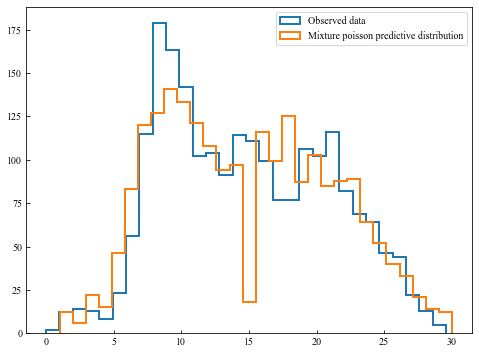

In [53]:
i= 0
#令i= 0-11就能得出12组pa值。然后就得到原图了
prior1 = prior_inputdata_get1(['season','time'],[2,i],data)
prior2 = prior_dist_get2('Population',pop_salary_data)

distribution_number = 5
distribution_x, distribution_y, sample_x, sample_y = poisson_mix(prior1,prior2,distribution_number)
Z_point = get_xy_distribution(distribution_x,distribution_y,prior1)

In [54]:
X_pa1 = np.array(prior1.loc[:,['longitude','latitude']])

x_point = np.linspace(-20.0, 20.0,Z_point.shape[0])
y_point = np.linspace(-15.0, 15.0,Z_point.shape[1])
X_point, Y_point = np.meshgrid(x_point, y_point)
XX = np.array([X_point.ravel(), Y_point.ravel()]).T

answer1 = []
for i in range(len(x_point) -1):
    for j in range(len(y_point) - 1):
        
        temp_ = prior1[(prior1['longitude'] < x_point[i+1]) & (prior1['longitude'] > x_point[i])]
        temp_ = temp_[(temp_['latitude'] < y_point[j+1]) & (temp_['latitude'] > y_point[j])]
        predict = len(temp_)

        answer1.append([predict,Z_point[i,j]])
        
answer1 = np.array(answer1)
all_num = np.sum(answer1[:,0])
all_num2 = np.sum(answer1[:,1])
predict_p = (answer1[:,1] / all_num2)
true_p = (answer1[:,0] / all_num)
print('pa值：%.6f,(+- %.6f)'%(np.log(np.mean(abs(predict_p - true_p))),np.std(abs(predict_p - true_p))))

pa值：-7.042821,(+- 0.001574)


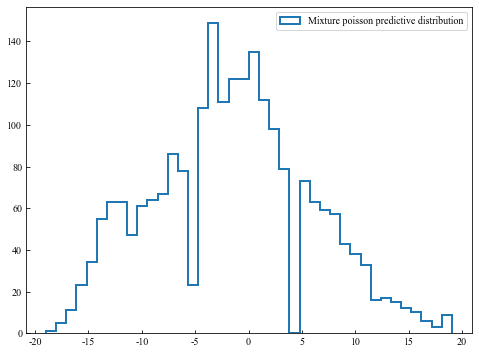

In [55]:
want_grid_x = 40
fig, ax = plt.subplots(figsize = (8,6))
ax.hist(np.array(sample_x) + 1, bins=want_grid_x,stacked=True,
        histtype='step', lw=2,
        label='Mixture poisson predictive distribution')
ax.legend(loc=1)
plt.show()

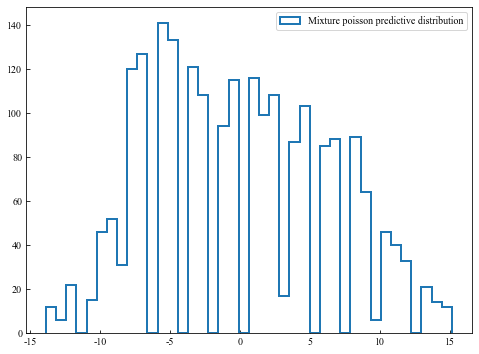

In [56]:
want_grid_y = 40
fig, ax = plt.subplots(figsize = (8,6))
ax.hist(np.array(sample_y) + 1, bins=want_grid_y,stacked=True,
        histtype='step', lw=2,
        label='Mixture poisson predictive distribution')
ax.legend(loc=1)
plt.show()

In [57]:
def gauss_mix(input_data,area_params = None,dis_num = 5,is_sample = True, plot_show = True):

    if is_sample == True:
        #对输入数据进行采样，因为有时候大几十万条训练时间太久了。
        if len(input_data) > 10000:
            input_data = input_data.loc[random.sample(range(len(input_data)),10000),:]
            input_data.reset_index(inplace = True,drop = True)
            
    input_data = np.array(input_data.loc[:,['longitude','latitude']])
    dpgmm = mixture.BayesianGaussianMixture(n_components=dis_num, covariance_type="full").fit(input_data)
    
    
    if area_params != None:
        if area_params[0] == 'both':
            longtitude_change_params1 = area_params[1][0]
            latitude_change_params1 = area_params[2][0]
            longtitude_change_params2 = area_params[1][1]
            latitude_change_params2 = area_params[2][1]            
        else:
            longtitude_change_params = area_params[1][0]
            latitude_change_params = area_params[2][0]
            
    x_point = np.linspace(-20, 20)
    y_point = np.linspace(-15, 15)
    X_point, Y_point = np.meshgrid(x_point, y_point)
    XX = np.array([X_point.ravel(), Y_point.ravel()]).T
    Z_point = -dpgmm.score_samples(XX)
    Z_point = Z_point.reshape(X_point.shape)
    
    if area_params != None:
        if area_params[0] == 'both':    
            Z_point = Z_point * (1 + np.linspace(-longtitude_change_params1,longtitude_change_params1,len(x_point)))
            Z_point = Z_point * (1 + np.linspace(-longtitude_change_params2,longtitude_change_params2,len(x_point)))
            Z_point = (Z_point.T * (1 + np.linspace(-latitude_change_params1,latitude_change_params1,len(y_point)))).T
            Z_point = (Z_point.T * (1 + np.linspace(-latitude_change_params2,latitude_change_params2,len(y_point)))).T
        else:
            Z_point = Z_point * (1 + np.linspace(-longtitude_change_params,longtitude_change_params,len(x_point)))
            Z_point = (Z_point.T * (1 + np.linspace(-latitude_change_params,latitude_change_params,len(y_point)))).T
    
    if plot_show:
        plt.figure(figsize = (15,10))
        levels = np.arange(np.min(Z_point), 9, 0.5)
        color_list = []
        for level in levels:
            #颜色有点淡，因为Z_point最小值是3-4左右。所以整体加深一点
            level = level - np.min(Z_point)
            color_list.append((level / 9,level / 9,level / 9))
        CS = plt.contourf(X_point, Y_point, Z_point,levels=levels, colors = color_list)

        CB = plt.colorbar(CS, shrink=0.8, extend="both")
        #plt.scatter(X[:, 0], X[:, 1],0.001, color = 'g')

        plt.title("posterior log spatial density using 15 components for Wednesday 2–4 p.m", fontsize = 18)
        plt.axis("tight")
        plt.xlabel('Kilometers eastward from center of toronto',fontsize = 12)
        plt.ylabel('Kilometers northward from center of toronto',fontsize = 12)
        plt.show()
    return Z_point

### 高斯混合也是一样使用上述prior

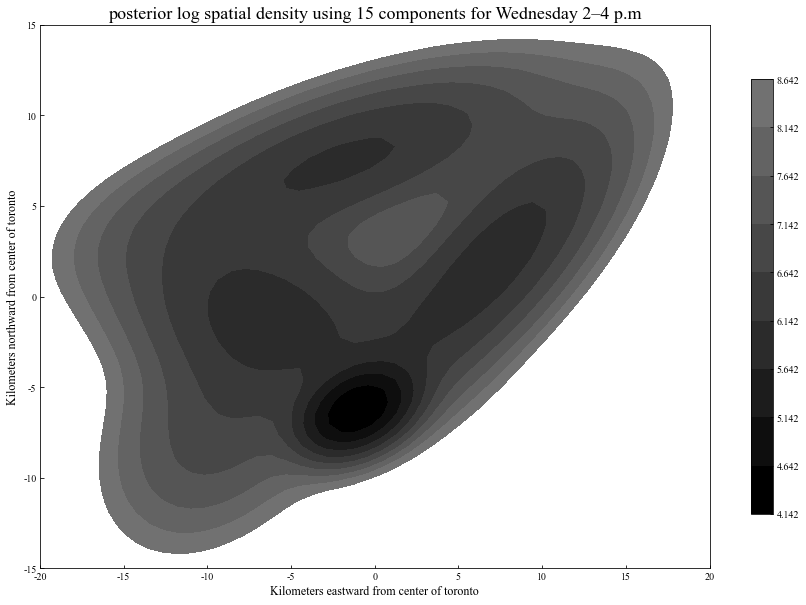

In [58]:
prior1 = prior_inputdata_get1(['season','time',],[2,0],data)
prior2 = prior_dist_get2('Population',pop_salary_data)
distribution_number = 5
Z_point = gauss_mix(prior1,prior2,distribution_number)

In [59]:
#首先获取需要计算pa值的部分数据

X_pa1 = np.array(prior1.loc[:,['longitude','latitude']])
dpgmm_pa1 = mixture.BayesianGaussianMixture(n_components=15, covariance_type="full").fit(X_pa1)

x_point = np.linspace(-20.0, 20.0)
y_point = np.linspace(-15.0, 15.0)
X_point, Y_point = np.meshgrid(x_point, y_point)
XX = np.array([X_point.ravel(), Y_point.ravel()]).T
Z_point1 = -dpgmm_pa1.score_samples(XX)
Z_point1 = Z_point1.reshape(X_point.shape)

answer1 = []
for i in range(len(x_point) -1):
    for j in range(len(y_point) - 1):
        
        temp_ = prior1[(prior1['longitude'] < x_point[i+1]) & (prior1['longitude'] > x_point[i])]
        temp_ = temp_[(temp_['latitude'] < y_point[j+1]) & (temp_['latitude'] > y_point[j])]
        predict = len(temp_)

        answer1.append([predict,Z_point1[i,j]])
        
answer1 = np.array(answer1)
all_num = np.sum(answer1[:,0])
all_num2 = np.sum(answer1[:,1])
predict_p = (answer1[:,1] / all_num2)
true_p = (answer1[:,0] / all_num)
print('Original pa值：%.6f,(+- %.6f)'%(np.log(np.mean(abs(predict_p - true_p))),np.std(abs(predict_p - true_p))))



answer1 = []
for i in range(len(x_point) -1):
    for j in range(len(y_point) - 1):
        
        temp_ = prior1[(prior1['longitude'] < x_point[i+1]) & (prior1['longitude'] > x_point[i])]
        temp_ = temp_[(temp_['latitude'] < y_point[j+1]) & (temp_['latitude'] > y_point[j])]
        predict = len(temp_)
        
        answer1.append([predict,Z_point[i,j]])
        
answer1 = np.array(answer1)
all_num = np.sum(answer1[:,0])
all_num2 = np.sum(answer1[:,1])
predict_p = (answer1[:,1] / all_num2)
true_p = (answer1[:,0] / all_num)
print('after-prior pa值：%.6f,(+- %.6f)'%(np.log(np.mean(abs(predict_p - true_p))),np.std(abs(predict_p - true_p))))

Original pa值：-7.373950,(+- 0.000848)
after-prior pa值：-7.408762,(+- 0.000828)
